In [23]:
import flopy as fp
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size']=12
import pandas as pd
import os
import sys

In [2]:
workspace = "workspace"
model_name = "test_mf6_pst"
exe_name="../../exe/mf6.exe"

nrow = 10
ncol = 10

In [3]:
def model_run(k):
    
    # spatial param
    nlay = 1
    delc = 10
    delr = 10
    top = 10
    botm = 0

    # packages
    sim = fp.mf6.MFSimulation(sim_name=model_name, version='mf6', exe_name=exe_name, 
                                 sim_ws=workspace)
    tdis = fp.mf6.ModflowTdis(sim, pname='tdis', time_units='SECONDS', 
                                 nper=1, perioddata=[(1.0, 1, 1.0)])
    gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                               model_nam_file='{}.nam'.format(model_name))
    dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,top=top, botm=botm)
    ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity="simple")
    ic   = fp.mf6.ModflowGwfic(gwf,strt=botm+1)

    oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                                head_filerecord='{}.hds'.format(model_name),
                                saverecord=[('HEAD', 'LAST'),
                                            ('BUDGET', 'LAST')],
                                printrecord=[('HEAD', 'ALL')])
    

    npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=k,save_flows=True)
    
    #bc
    chd = []
    for irow in range(nrow):
        chd.append(((0,irow,0),10))
        chd.append(((0,irow,ncol-1),0))
    chd = fp.mf6.ModflowGwfchd(gwf,pname="chd",filename="bc.chd",maxbound=len(chd),stress_period_data=chd,save_flows=True)
    
    
    
    lst_pts = []
    for irow in range(1,nrow-1):
        for icol in range(1,ncol-1):
            lst_pts.append((0,irow,icol))
            
    obs_lst1=[]
    for pts in lst_pts:
        obs_lst1.append(("0_{}_{}".format(pts[1],pts[2]),"HEAD",pts))

    obs_recarray = {('heads.csv'):obs_lst1}
    obs_package = fp.mf6.ModflowUtlobs(gwf, pname='head_obs', filename='{}.obs'.format(model_name), 
                                          digits=10, print_input=True,
                                          continuous=obs_recarray)
    
    
    sim.write_simulation(silent=True)
    sim.run_simulation()

In [4]:
np.random.seed(4)
-1e-4*np.random.rand(nrow*ncol)*np.log(np.random.rand(nrow*ncol)) 

array([1.29923666e-04, 4.84621460e-05, 8.46043905e-05, 7.33924303e-06,
       1.43692740e-06, 1.02058229e-05, 2.42770050e-04, 1.93518783e-07,
       9.80553523e-06, 8.31029325e-06, 8.23909584e-05, 5.59893989e-05,
       4.24000821e-05, 2.05270714e-04, 4.50658043e-06, 1.37469726e-05,
       8.04213544e-07, 2.23606910e-06, 7.72786147e-06, 5.65652413e-06,
       3.33506234e-05, 2.56703658e-05, 2.23254965e-05, 1.64325182e-06,
       4.69027711e-07, 2.41079647e-05, 2.48525061e-04, 1.02481753e-05,
       2.48249240e-04, 1.71274350e-05, 3.30297031e-05, 3.80304843e-05,
       4.26715151e-05, 1.40675353e-05, 8.17094778e-07, 1.72875141e-05,
       2.65527458e-04, 1.47245255e-04, 1.84428119e-05, 8.08790934e-05,
       3.56184332e-05, 1.53795512e-05, 7.96602674e-05, 1.37966986e-06,
       1.23142400e-05, 2.98675750e-05, 1.17382479e-04, 2.26433244e-05,
       1.50141828e-05, 5.77798085e-07, 2.33582426e-04, 7.27272789e-05,
       1.91933145e-05, 3.48019037e-06, 1.20549523e-04, 3.41229628e-06,
      

In [5]:
# generate random permeability array for the inversion
np.random.seed(4)
k = -1e-4*np.random.rand(nrow*ncol)*np.log(np.random.rand(nrow*ncol)) 
filnm = "k.txt"
np.savetxt(os.path.join(workspace,filnm),k)
model_run(filnm)

FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources Soft

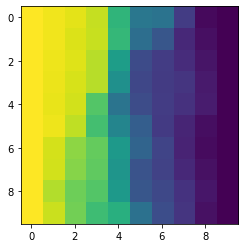

In [6]:
plt.imshow(fp.utils.HeadFile("workspace/test_mf6_pst.hds").get_data((0,0))[0])

Setup PEST

In [7]:
import pyemu

In [8]:
sim = fp.mf6.MFSimulation.load(sim_ws=workspace)
m = sim.get_model("test_mf6_pst")

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package chd...
    loading package obs...
  loading ims package test_mf6_pst...


Get spatialReference

In [9]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(workspace, "{}.nam".format(model_name)),
        delr=m.dis.delr.array, delc=m.dis.delc.array)
sr

   could not remove start_datetime


xul:0; yul:100; rotation:0; proj4_str:None; units:meters; lenuni:2; length_multiplier:1.0

In [10]:
# empty pst from object
template_ws = "template"
pf = pyemu.prototypes.PstFrom(original_d=workspace, new_d=template_ws,
                 remove_existing=True,
                 longnames=True, spatial_reference=sr,
                 zero_based=False)

2020-06-28 09:46:58.091069 starting: opening PstFrom.log for logging
2020-06-28 09:46:58.091069 starting PstFrom process
2020-06-28 09:46:58.101131 starting: setting up dirs
2020-06-28 09:46:58.109167 starting: removing existing new_d 'template'
2020-06-28 09:46:58.139337 finished: removing existing new_d 'template' took: 0:00:00.030170
2020-06-28 09:46:58.139337 starting: copying original_d 'workspace' to new_d 'template'
2020-06-28 09:46:58.161475 finished: copying original_d 'workspace' to new_d 'template' took: 0:00:00.022138
2020-06-28 09:46:58.161475 finished: setting up dirs took: 0:00:00.060344


In [11]:
#add observation
df = pd.read_csv(os.path.join(template_ws,"heads.csv"),index_col=0)

hds_df = pf.add_observations("heads.csv",insfile="heads.csv.ins",index_cols="time",
                use_cols=list(df.columns.values),prefix="hds",obsgp=False)

# pf.obs_dfs[0].iloc[1:5,2]=0.5 # change weight for fun

2020-06-28 09:46:58.350785 starting: adding observations from tabular output file
2020-06-28 09:46:58.350785 starting: reading list template\heads.csv
2020-06-28 09:46:58.352808 finished: reading list template\heads.csv took: 0:00:00.002023
2020-06-28 09:46:58.360849 starting: building insfile for tabular output file heads.csv
2020-06-28 09:46:58.433333 finished: building insfile for tabular output file heads.csv took: 0:00:00.072484
2020-06-28 09:46:58.433333 starting: adding observation from instruction file 'template\heads.csv.ins'
2020-06-28 09:46:58.463563 finished: adding observation from instruction file 'template\heads.csv.ins' took: 0:00:00.030230
2020-06-28 09:46:58.463563 finished: adding observations from tabular output file took: 0:00:00.112778


In [12]:
case = "mf6_test_1"
pf.build_pst("{}.pst".format(case))

noptmax:30, npar_adj:0, nnz_obs:64


#### Parameters

spatial variogram


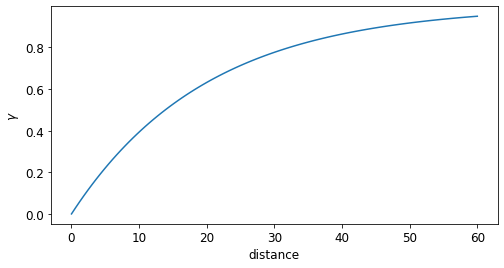

In [24]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=20)
grid_gs = pyemu.geostats.GeoStruct(variograms=v, transform='log')

fig = plt.figure(figsize=(8,4))
grid_gs.plot()
print("spatial variogram")

In [14]:
hk_arr_files = [f for f in os.listdir(template_ws) if "k" in f and f.endswith(".txt")]
hk_arr_files

['k.txt']

In [15]:
# set an homogeneous k array (as initial value)
k = 1e-4*np.ones([nrow,ncol])
filnm = "k.txt"
np.savetxt(os.path.join(template_ws,filnm),k)

In [16]:
pf.add_parameters(filenames="k.txt",par_type="pilotpoint",pp_space=2,
                   par_name_base="kp",pargp="hp",
                   upper_bound=10.,lower_bound=0.1,ult_ubound=1e-3,ult_lbound=1e-6,geostruct=grid_gs)

2020-06-28 09:47:00.385663 starting: adding pilotpoint type multiplier style parameters for file(s) ['k.txt']
2020-06-28 09:47:00.387687 starting: loading array template\k.txt
2020-06-28 09:47:00.387687 finished: loading array template\k.txt took: 0:00:00
2020-06-28 09:47:00.387687 loaded array 'k.txt' of shape (10, 10)
2020-06-28 09:47:00.387687 starting: writing array-based template file 'kp_inst0_pilotpoint.csv.tpl'
2020-06-28 09:47:00.387687 starting: setting up pilot point parameters
2020-06-28 09:47:00.387687 No spatial reference (containing cell spacing) passed.
2020-06-28 09:47:00.395719 OK - using spatial reference in parent object.
ibound not passed, using array of ones
2020-06-28 09:47:00.578982 16 pilot point parameters created
2020-06-28 09:47:00.578982 pilot point 'pargp':kp_inst:0
2020-06-28 09:47:00.578982 finished: setting up pilot point parameters took: 0:00:00.191295
2020-06-28 09:47:00.599104 starting: calculating factors for pargp=kp_inst:0
2020-06-28 09:47:00.5991

In [17]:
pf.build_pst("{}.pst".format(case))

noptmax:30, npar_adj:16, nnz_obs:64


In [18]:
# add run model command
pf.mod_sys_cmds.append("..\mf6")
pf.build_pst("{}.pst".format(case))

noptmax:30, npar_adj:16, nnz_obs:64
2020-06-28 09:47:10.211963 forward_run line:pyemu.os_utils.run(r'..\mf6')



In [19]:
#Rewrite ins file because Pyemu isn't smart enough

file = "template/heads.csv.ins"
fileout = "template/heads2.csv.ins"
with open(file) as f:
    with open(fileout,"w") as fout:
        for i,line in enumerate(f):
            if i < 2:
                fout.write(line)
            if i > 1:
                for o,split in enumerate(line.split("w")):
                    if o == 1:
                        fout.write("~,~")
                    fout.write(split)
                        
from shutil import copyfile
copyfile(fileout, file) # copy 
os.remove(fileout) # delete tmp file

noptmax:30, npar_adj:16, nnz_obs:64
2020-06-28 11:17:18.307738 WARNING: sys_cmd 'pyemu.os_utils.run(r'..\mf6')
' already in sys cmds, skipping...
2020-06-28 11:17:18.307738 starting: building prior covariance matrix
2020-06-28 11:17:18.323364 saving prior covariance matrix to file template\mf6_test_1.prior.cov
2020-06-28 11:17:18.323364 finished: building prior covariance matrix took: 0:00:00.015626


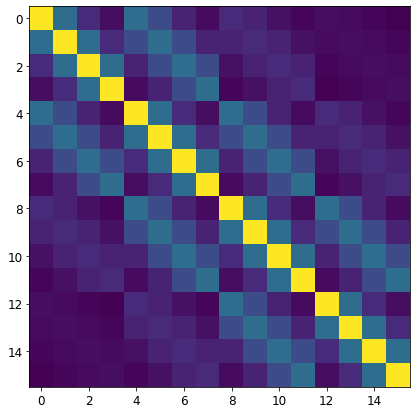

In [35]:
pst = pf.build_pst("{}.pst".format(case))
cov = pf.build_prior()
x = cov.x.copy()
x[x==0.0] = np.NaN
fig,ax = plt.subplots(1,1,figsize=(7,7))
g = ax.imshow(x)

In [29]:
pe = pf.draw(num_reals=100,use_specsim=True)

2020-06-28 09:58:25.422353 starting: drawing realizations
2020-06-28 09:58:25.430388 starting: spectral simulation for grid-scale pars
2020-06-28 09:58:25.432448 finished: spectral simulation for grid-scale pars took: 0:00:00.002060
building diagonal cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:20.0,anisotropy:1.0,bearing:0.0

working on pargroups ['kp_inst:0']
build cov matrix
done
getting diag var cov 16
scaling full cov by diag var cov
adding remaining parameters to diagonal
2020-06-28 09:58:25.472727 finished: drawing realizations took: 0:00:00.050374


0     2.086913
1     0.746829
2     1.063467
3     1.499560
4     2.770342
        ...   
95    0.925538
96    1.234135
97    0.850076
98    0.975223
99    0.559196
Name: kp_inst:0_i:1_j:1, Length: 100, dtype: float64


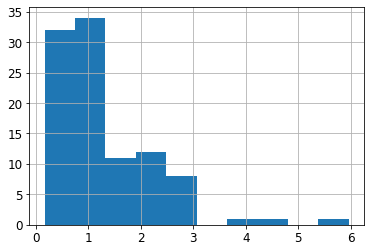

In [30]:
print(pe.loc[:,pst.adj_par_names[0]])
pe.loc[:,pst.adj_par_names[0]]._df.hist()

In [31]:
t_d = "template"
m_d = "master_glm"

pst.control_data.noptmax = -1 # FOR JACOBIAN
pst.write(os.path.join(t_d,"{}.pst".format(case)))

noptmax:-1, npar_adj:16, nnz_obs:64


In [21]:
#pyemu.os_utils.start_workers(t_d,"../pestpp-glm.exe","mf6_test_1.pst",num_workers=1,worker_root=".",master_dir=m_d)

In [32]:
# fill JACOBIAN
pyemu.os_utils.run("..\pestpp-glm.exe {}".format(case),cwd="template")